In [2]:

import torch
import torch.optim as optim
import torch
from torch.utils.data import DataLoader

import segmentation_models_pytorch as smp

import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import torchmetrics as tm
from torchmetrics.segmentation import MeanIoU

from config import Config
from dataset import *
from utils import DiceCELossSplitter, plot_img_label_pred
from transforms import ImageVisualizer
import wandb

import monai
from monai.transforms import *

from tabulate import tabulate
import matplotlib.pyplot as plt

seed_everything(99, workers=True)


Seed set to 99


99

In [3]:
# globally set source domains for SVDNA and for dataset preppning
cfg = Config(source_domains = ["Spectralis"])
cfg.batch_size = 4
cfg.epochs = 100

To change experimental setting, check the following:

- source domains in the OCTDatasetPrep class
- Turn on SVDNA in the config file

In [4]:
train_data, val_data, test_data = OCTDatasetPrep(cfg.train_dir,
                                                 source_domains = cfg.source_domains,
                                                ).get_datasets(dataset_split=[0.7, 0,3], use_official_testset=True)

train_dataset = MakeDataset(train_data, cfg.train_transforms)
val_dataset = MakeDataset(val_data, cfg.val_transforms)
test_dataset = MakeDataset(test_data, cfg.test_transforms)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=7, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)

Total dataset length:  4956
Training set: 584
Validation set: 249
Test set: 4123


In [5]:
from lightning.pytorch.plugins.environments import SLURMEnvironment
SLURMEnvironment.detect = lambda: False

In [6]:
class LitUNetPlusPlus(L.LightningModule):
    def __init__(self, cfg, model):
        super().__init__()
        self.cfg = cfg
        #self.save_hyperparameters(ignore=['model'])
        self.save_hyperparameters()
        self.model = model
        self.loss_func = DiceCELossSplitter(include_background=False, sigmoid=True, lambda_ce=0.5)

        # several metrics

        avg = 'micro'
        num_classes = 2

        # validation
        self.val_accuracy = tm.classification.Accuracy(task="binary", num_classes=num_classes)
        self.val_f1 = tm.classification.F1Score(task="binary", num_classes=num_classes)
        self.val_precision = tm.classification.Precision(task="binary", average=avg, num_classes=num_classes)
        self.val_recall = tm.classification.Recall(task="binary", average=avg, num_classes=num_classes)
        self.val_specificity = tm.classification.Specificity(task="binary", average=avg, num_classes=num_classes)
        self.val_iou = MeanIoU(num_classes=num_classes, per_class=True, include_background=False)

        # test
        self.test_accuracy = tm.classification.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_f1 = tm.classification.F1Score(task="multiclass", num_classes=num_classes)
        self.test_precision = tm.classification.Precision(task="multiclass", average=avg, num_classes=num_classes)
        self.test_recall = tm.classification.Recall(task="multiclass", average=avg, num_classes=num_classes)
        self.test_specificity = tm.classification.Specificity(task="multiclass", average=avg, num_classes=num_classes)
        self.test_iou = MeanIoU(num_classes=num_classes, per_class=True, include_background=False)

    def training_step(self, batch, batch_idx):
        inputs = batch['img'].to(self.cfg.device)
        #labels = sample['label'].to(device)
        masks = batch['masks'].to(self.cfg.device)

        outputs = self.model(inputs)
        dice_loss, ce_loss, total_loss = self.loss_func(outputs, masks)

        #print(f"Total loss: {total_loss.item()} | Dice loss: {dice_loss.item()} | CE loss: {ce_loss.item()}")

        self.log('train_loss_dice', dice_loss.item())
        self.log('train_loss_ce', ce_loss.item())
        self.log('train_loss_total', total_loss.item())
        torch.cuda.empty_cache()
        return total_loss
    
    def validation_step(self, batch, batch_idx):
        inputs = batch['img'].to(self.cfg.device)
        #labels = sample['label'].to(device)
        masks = batch['masks'].to(self.cfg.device)

        outputs = self.model(inputs)
        # try splitting losses
        dice, ce, total_loss = self.loss_func(outputs, masks)

        output_to_save = torch.sigmoid(outputs[:5])

        # thresholding
        output_to_save[output_to_save > 0.5] = 1
        output_to_save[output_to_save <= 0.5] = 0

        for i in range(output_to_save.shape[0]):
            img_path = os.path.join(cfg.validation_img_path, f"b{batch_idx}img{i+1}.png")
            cv2.imwrite(img_path, output_to_save[i, :, :, :].permute(1, 2, 0).cpu().numpy() * 255)

        self.log('val_loss_total', total_loss)
        self.log('val_loss_dice', dice)
        self.log('val_loss_ce', ce)

        self.log('val_accuracy', self.val_accuracy(outputs, masks.long()))
        self.log('val_f1', self.val_f1(outputs, masks.long()))
        self.log('val_precision', self.val_precision(outputs, masks.long()))
        self.log('val_recall', self.val_recall(outputs, masks.long()))
        self.log('val_specificity', self.val_specificity(outputs, masks.long()))

        return total_loss
    
    def test_step(self, batch, batch_idx):
        inputs = batch['img'].to(self.cfg.device)
        #labels = sample['label'].to(device)
        masks = batch['masks'].to(self.cfg.device)

        outputs = self.model(inputs)
        #loss = self.loss_func(outputs, masks)
        # try splitting losses
        dice, ce, total_loss = self.loss_func(outputs, masks)

        torch.sigmoid_(outputs)

        # thresholding
        outputs[outputs > 0.5] = 1
        outputs[outputs <= 0.5] = 0

        self.log('test_loss_total', total_loss)
        self.log('test_loss_dice', dice)
        self.log('test_loss_ce', ce)

        self.log('test_accuracy', self.test_accuracy(outputs, masks.long()))
        self.log('test_f1', self.test_f1(outputs, masks.long()))
        self.log('test_precision', self.test_precision(outputs, masks.long()))
        self.log('test_recall', self.test_recall(outputs, masks.long()))
        self.log('test_specificity', self.test_specificity(outputs, masks.long()))
        #self.log('test_iou', self.test_iou(outputs.long(), masks.long()))
        
        return total_loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=self.cfg.factor, patience=self.cfg.patience_lr)
        return {"optimizer": optimizer, 
                "lr_scheduler": {'scheduler': scheduler, 'monitor': 'val_loss_total'}}
    
    def forward(self, x):
        return self.model(x)
    

model = smp.UnetPlusPlus(**cfg.model_parameters_unetpp)
    
unetpp = LitUNetPlusPlus(cfg, model)

wandb_logger = WandbLogger(project="PracticalWorkinAI")

checkpoint_callback = ModelCheckpoint(dirpath=cfg.model_path, monitor='val_loss_total', mode='min')
lr_monitor = LearningRateMonitor(logging_interval='step')


trainer = L.Trainer(max_epochs=cfg.epochs, 
                    accumulate_grad_batches=8,
                    logger=wandb_logger, 
                    default_root_dir=Path(cfg.default_root_dir),
                    log_every_n_steps=2,
                    callbacks=[checkpoint_callback, lr_monitor],
                    deterministic=True)

/home/moritz/miniconda3/envs/optima/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(unetpp, train_dataloaders=train_loader, val_dataloaders=val_loader)
#trainer.test(unetpp, dataloaders=val_loader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: moritsih. Use `wandb login --relogin` to force relogin


/home/moritz/miniconda3/envs/optima/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/moritz/Documents/practicalAI/OPTIMA_Masterarbeit/practical/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name             | Type                  | Params
------------------------------------------------------------
0  | model            | UnetPlusPlus          | 41.0 M
1  | loss_func        | DiceCELossSplitter    | 0     
2  | val_accuracy     | BinaryAccuracy        | 0     
3  | val_f1           | BinaryF1Score         | 0     
4  | val_precision    | BinaryPrecision       | 0     
5  | val_recall       | BinaryRecall          | 0     
6  | val_specificity  | BinarySpecificity     | 0     
7  | val_iou          | MeanIoU               | 0     
8  | test_accuracy    | MulticlassAccuracy    | 0     
9  | test_f1          | MulticlassF1Score     | 0     
10 | test_precision   | MulticlassPrecision   | 0     


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/moritz/miniconda3/envs/optima/lib/python3.10/site-packages/torch/_tensor.py:1443: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  ret = func(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.
SVDNA performed.


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 

In [ ]:
wandb.finish()

## Visualization and results

### Visualize some images and masks

In [7]:
print_some_imgs = False

if print_some_imgs:
    
    transforms_visualize = Compose([cfg.train_transforms, ImageVisualizer(keys=['img', 'label', 'masks'])])
    train_data_raw, _, _ = OCTDatasetPrep(cfg.train_dir, source_domains=cfg.source_domains).get_datasets(use_official_testset=False)
    train_data = MakeDataset(train_data_raw, transforms_visualize)


    for i in range(4):
 
        rand_num = np.random.randint(0, len(train_data))
        sample = train_data[rand_num]
        print(f"Sample {i+1}", 
              "\nImg: ", sample['img'].shape,
              "\nLabel: ", sample['label'].shape,
              "\nMasks: ", sample['masks'].shape)




### Load model and make predictions on random images from validation set

In [8]:
model_checkpoints = os.listdir(cfg.model_path)
print(model_checkpoints)

['untrained_baseline.ckpt']


In [9]:
get_predictions = False

if get_predictions:
    model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
    model.eval()

    for i in range(np.min([5, len(val_dataset)])):
        rand_num = np.random.randint(0, len(val_dataset))
        sample = val_dataset[rand_num]

        img = sample['img'].unsqueeze(0).to(cfg.device)
        mask = sample['masks'].unsqueeze(0).to(cfg.device)

        pred = model(img)
        pred = torch.sigmoid(pred)
        
        # thresholding
        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0

        plot_img_label_pred(img, pred, mask)

In [10]:

#model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
#table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'ImageNet pretrained'))

#model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
#table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'Supervised training'))

#model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
#table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'SVDNA source: Spectralis'))

#model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
#table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'SVDNA source: Cirrus'))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# save variable table to text file
#print(tabulate(table, headers='firstrow', tablefmt='github'))
#with open('results.txt', 'w') as f:
#    f.write(tabulate(table, headers='firstrow', tablefmt='latex_raw'))

|             |           | Model   | IRF      | SRF         | PED      |
|-------------|-----------|---------|----------|-------------|----------|
| dice_scores | precision | recall  | accuracy | specificity | f1 score |
| dice_scores | precision | recall  | accuracy | specificity | f1 score |
| dice_scores | precision | recall  | accuracy | specificity | f1 score |
| dice_scores | precision | recall  | accuracy | specificity | f1 score |


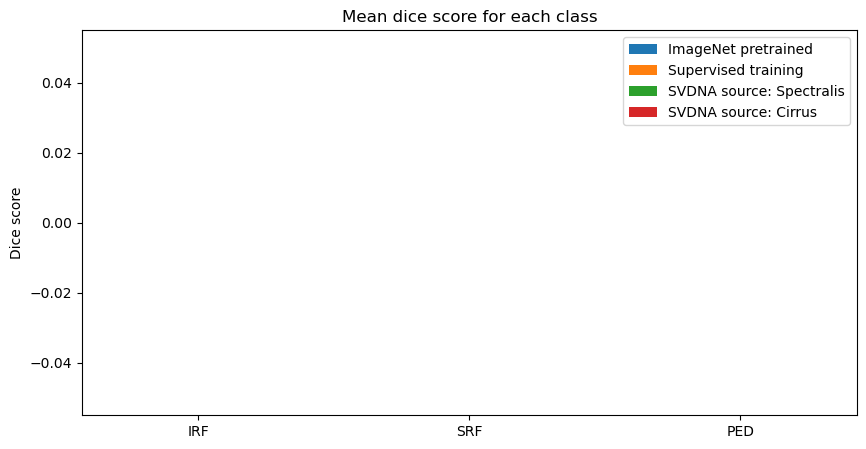

In [9]:
# make a barplot with three bars, one for each class

'''fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(3)
width = 0.15

for i, model in enumerate(table[1:]):
    ax.bar(x + i*width, model[1:], 0.15, label=model[0])

ax.set_xticks(x + width*1.5)
#ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticklabels(['IRF', 'SRF', 'PED'])
ax.set_ylabel('Dice score')
ax.set_title('Mean dice score for each class')

ax.legend()
plt.show()'''